# Movie Recommender System using Boltzmann Machines

### Objective
* The objective here is to create a Recommender System with a binary output YES/NO to predict whether or not the viewer will like a particular movie
* This project is sort of a Deep Case Study on RBM which focuses purely upon implementing the theoritical knowledge of a Restricted Boltzmann Machine into Python

### Data Source
* GroupLens Research has collected and made available rating data sets from the MovieLens web site (http://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. 
* It has 1 million ratings from 6000 users on 4000 movies. Released in FEB/2003. 

### Why Pytorch?
* Is has proven more useful and effective than tensorflow when it comes to implementing Boltzmann Machines and Auto Encoders
* Theano and Tensorflow can be used to implement the same but the framework of Pytorch makes implementation more easier
* It is more inutuitive, practical and flexible to make any changes in the architecture of your model when it comes to Pytorch

### Goals of this Project :
* Implementing and knowing the significance of Pytorch and performing Tensor operations
* To make our own class to implement Restricted Boltzmann Machines
* Understanding how an RBM works 
* Understanding the techniques of k-step contrastive divergence, updating the weights, probabilities of hidden and visible nodes, etc
* Calculating the loss function and interpreting the loops and what happens at the backend of an RBM

### Step - 1
Importing the import Libraries

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn                 # the torch module to implement the Neural Networks
import torch.nn.parallel              # for parallel computations
import torch.optim as optim           # for optimizers
import torch.utils.data               # tools
from torch.autograd import Variable   # for Stochastic Gradient Descent

### Step - 2
Importing the Movies data

**Arguments used -**
* Its a `.dat` file which is seperated by `'::'` hence the `sep` is given so
* Doesn't has a `header` hence set to `None`
* `engine` = python to make sure dataset gets imported correctly
* `encoding = latin-1` as some movie titles contain special characters

In [2]:
movies = pd.read_csv('../input/movie-data/ml-1m/movies.dat', sep = '::', 
                    header = None, engine = 'python', encoding = 'latin-1')
movies.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


* The 1st column is nothing but the `Movie ID`
* And this is the info we will use to build a Recommender System rather than on the `Movie Title` which is the 2nd column
* The 3rd column is the `Genre` of the Movie

**Note -**
* This Dataset is shown here to give you the idea of the movies
* We are not going to use this data to make training/testing set

### Step - 2
* Importing the Users Data
* Yet again we will be just seeing the dataset and not work on it

In [3]:
users = pd.read_csv('../input/movie-data/ml-1m/users.dat', sep = '::', 
                    header = None, engine = 'python', encoding = 'latin-1')
users.head()

,0,1,2,3,4
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


* 1st column is the `User ID`
* 2nd column is the `Gender`
* 3rd column is the `Age`
* 4th column contain's `some codes corresponding to the users job`
* The last column is the `Zip Code`

### Step - 3
* Importing the Ratings Data

In [4]:
ratings = pd.read_csv('../input/movie-data/ml-1m/ratings.dat', sep = '::', 
                    header = None, engine = 'python', encoding = 'latin-1')
ratings.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
ratings.shape

(1000209, 4)

This Data has over 1 million observations and 4 columns

* 1st columns corresponds to `Users` and the `1` that we see here is the `1st User` in this Database
* 2nd column corresponds to `Movies` and the numbers in it are `Movie IDs`
* The 3rd column corresponds to the `Ratings` from `1 to 5` 
* 4th column corresponds to the `TimeStamps` when the user rated the movie which has no relevance to our model

### Step - 4
* Importing the Training and Testing set
* But as a million observations would take a lot of time to process on we load another dataset having same columns but only 100k observations
* Out of these 100k, we take 80% in the training set
* A point to note that we already have training and testing set seperately given by the MovieLens Dataset

In [6]:
train_set = pd.read_csv('../input/movie-data/ml=100k/u1.base', delimiter = '\t') 
train_set.head()

,1,1.1,5,874965758
0,1,2,3,876893171
1,1,3,4,878542960
2,1,4,3,876893119
3,1,5,3,889751712
4,1,7,4,875071561


**Step - 4.1**
* Converting the dataframe to array
* Done because Pytorch works best with arrays and not dataframes

In [7]:
train_set = np.array(train_set, dtype = 'int')
train_set.dtype

dtype('int64')

**Step - 4.2**
* Doing the same for test set

In [8]:
test_set = pd.read_csv('../input/movie-data/ml=100k/u1.test', delimiter = '\t') 
test_set = np.array(test_set, dtype = 'int')
test_set.dtype

dtype('int64')

### Step - 5
* Getting total number of Users and Movies

**Why do this?**
* Because in the next step we are going to convert the training and test set into a matrix where the lines will be the Users and the columns are going to be Movies and cells are going to be Ratings
* And in each of the matrices, we will be including all the Users and Movies from the Orignal Dataset
* If any User didn't give a rating, then a 0 will be added in the cell that corresponds to this user and that movie
* These matrices are going to have same number of movies and same number of users, will have same number of rows and same number of columns
* In each of these matrices, each cell of index `Ui` (U is the user and i is the movie) will get the rating for the movie `i` by the user `U`
* And if this User `U` didn't rate the movie `i`, I will put a 0

In [9]:
print('There are', train_set[:,0].max(), 'Users in Training Set')
print('There are', train_set[:,1].max(), 'Movies in Training Set')
print('There are', test_set[:,0].max(), 'Users in Testing Set')
print('There are', test_set[:,1].max(), 'Movies in Testing Set')

There are 943 Users in Training Set
There are 1682 Movies in Training Set
There are 462 Users in Testing Set
There are 1591 Movies in Testing Set


* This tells us that the Maximum number of Users is 943 in train set and 462 in test set, which means the last User ID is available in train set which means this number is the total number of users
* Same goes for the total number of Movies
* Hence we consider total number of Users as **943** and total number of Movies as **1682**
* But to make it a global function as the maximum may lie in the test data sometimes and we want our code to automatically select the max of the max of train and test set. Hence we do the following

In [10]:
t_users = int(max(max(train_set[:,0]), max(test_set[:,0])))
t_movies = int(max(max(train_set[:,1]), max(test_set[:,1])))

print(f'The total number of Users are {t_users} and total number of Movies are {t_movies}')

The total number of Users are 943 and total number of Movies are 1682


### Step - 6
* Converting the data into array with `Users` in lines and `Movies` in columns
* The reason for doing step 5 will make sense here
* The reason for such restructuring of the data is to get the data into a format of inputs acceptable by the **Restricted Boltzmann Machine (RBM)**
* RBM is a form of NN where there are some input nodes, features and observations going one by one into the network starting with the input node
* This is why there is a need to create this array with `observations` in lines and `features` in columns

**Step - 6.1**

We are going to do this on training as well as test set. Hence it is better to create a function for this
* Here we don't create a 2D array but a list of lists, i.e one list for each line/observation or user
* Since we have 943 users, hence we will have 943 lists and they will be horizontal. The 1st list will correspond to 1st user and so on
* And in each list we will have the ratings of 1682 movies by the user corresponding to the list
* Hence rating for each movie by the user will be stored and if the user didn't rate a particular movie. Then we will get a 0 for that cell
* This explains that the training and test set will have the same size because for noth of them we are considering all the movies and all the users and what we do is put a 0 when a user doesn't rate a movie

In [11]:
def convert(dataset):
    new_data = []                               
    for user_id in range(1, (t_users + 1)):       
        movie_ids = dataset[:,1][dataset[:,0]==user_id]
        rating_ids = dataset[:,2][dataset[:,0]==user_id]
        ratings = np.zeros(t_movies)
        ratings[movie_ids - 1] = rating_ids 
        new_data.append(list(ratings))
    
    return new_data

**Understanding the function and for loop**
* First we initialize the list as new_data
* Then we make a for loop to take all the user ids from the 1 to the max no. of total users
* `t_users+1` because the range operator ignores the last index and we want all the total users
* Then we get movie_ids of the all movies for this user, i.e the movies watched by the user and rated as well currently in the loop
* Now we also want ratings for those movies he watched hence again a condition is applied as shown above
* As we have obtained the list of movies which the user rated, so the next step would be creating a list of movies which the user didn't rate as well. The elements of this list will correspond to total movies (1682 in this case) and for each movie the user rated we get 1 and 0 if not rated
* Hence we initialize a list of 1682 zeros and then for that movie that particular user rated, we are going to replace the 0 by the rating actually given by that user by using the movie_ids variable created 
* `movie_ids - 1` is done because the ratings will have the indexing starting from 0 and the movie_ids from 1. Thus to match this difference and avoid it from assigning the 2nd element of movie_ids to the 1st element of ratings, we do a `-1`. We assign this to `rating_ids` as they are real ratings
* In short we managed to create for each user, the list of all the ratings including the 0s for the movies that weren't rated
* Now we need to add this list of ratings corresponding to 1 user the `new_data` list that will contain all the different lists for all different users

In [12]:
# applying the function above to training and test set
train_set = convert(train_set)
test_set = convert(test_set)

How to interpret these values -

In [13]:
train_set[0:1]

[[0.0,
  3.0,
  4.0,
  3.0,
  3.0,
  0.0,
  4.0,
  1.0,
  5.0,
  0.0,
  2.0,
  0.0,
  5.0,
  0.0,
  5.0,
  5.0,
  0.0,
  4.0,
  5.0,
  0.0,
  1.0,
  4.0,
  0.0,
  0.0,
  4.0,
  3.0,
  0.0,
  4.0,
  1.0,
  3.0,
  0.0,
  5.0,
  0.0,
  2.0,
  1.0,
  0.0,
  2.0,
  3.0,
  0.0,
  3.0,
  2.0,
  5.0,
  4.0,
  0.0,
  5.0,
  4.0,
  0.0,
  5.0,
  0.0,
  5.0,
  0.0,
  4.0,
  0.0,
  0.0,
  5.0,
  0.0,
  5.0,
  4.0,
  5.0,
  0.0,
  0.0,
  0.0,
  2.0,
  0.0,
  0.0,
  4.0,
  0.0,
  4.0,
  0.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  4.0,
  0.0,
  4.0,
  0.0,
  4.0,
  0.0,
  0.0,
  0.0,
  3.0,
  0.0,
  0.0,
  0.0,
  5.0,
  4.0,
  5.0,
  0.0,
  0.0,
  0.0,
  5.0,
  2.0,
  4.0,
  0.0,
  0.0,
  0.0,
  3.0,
  0.0,
  2.0,
  0.0,
  0.0,
  0.0,
  2.0,
  4.0,
  0.0,
  0.0,
  5.0,
  1.0,
  5.0,
  0.0,
  0.0,
  0.0,
  5.0,
  3.0,
  0.0,
  0.0,
  5.0,
  0.0,
  0.0,
  3.0,
  4.0,
  5.0,
  0.0,
  2.0,
  5.0,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  4.0,
  0.0,
  4.0,
  3.0,
  5.0,
  1.0,
  3.0,
  0.0,
  3.0,
  2.0,
  0.0,

**Conclusions from the above operations -**
* The 1st 3 elements `0`, `3` and `4` represent that the 1st user **didn't rate the 1st movie** hence rating is 0, the **2nd movie was watched and rated 3** and **3rd movie was watched and rated 4** respectively
* For any deep learning model, lines are observations going into the network and columns are features that are going to be the input nodes in the network
* Hence for each user we will have ratings of all movies and 0s included, hence these ratings are going to be the input nodes for this observation going into the network
* This is how the architecture is supposed to be and that can be built using Pytorch Tensors

### Step - 7
* Converting data into Torch Tensors
* Pytorch Tensors are nothing but the arrays that contain elements of a single datatype aka multidimensional matrix
* The only difference is that this is a pytorch array and not a numpy array
* A network can be built using numpy arrays but doesn't prove to be efficient than tensors

In [14]:
train_set = torch.FloatTensor(train_set)
test_set = torch.FloatTensor(test_set)

### Step - 8
* We are building a recommender system to predict whether a person will like the movie or not
* Hence, we will be converting our movie ratings ranging from `0 to 5` into a binary variable as `0 (liked)` and `1 (didn't like)`
* The reason for doing this is because the RBM takes the input vector, and inside this vector it will predict the ratings for the movies which weren't orignally rated by the user
* The predicted ratings are computed from the existing ratings of the input vector, hence the predicted ratings in the outputs must have same format as the existing ratings in the input

In [15]:
# first we replace all the zeros in train set by -1
# coz all the zeros are the non-existing ratings for a movie by a user
# now the new ratings are going to be 0(liked) and 1(disliked), hence the orignal zeros must now have the new value as -1
# thus, -1 will mean there wasn't a rating for a particular movie by a particular user

train_set[train_set == 0] = -1            # movies not rated will be represented by -1

# now we will change orignal ratings of 1 and 2 to 0, i.e. if the movie is rated 1 or 2, means that user disliked the movie
# also the 'or' logic cannot be used with tensors thus we do the operation for 1 and 2 seperately
train_set[train_set == 1] = 0
train_set[train_set == 2] = 0

# the original ratings greater than 3 will be considered as the user like the movie, hence we represent them by 1
train_set[train_set >= 3] = 1



# doing the same for test set
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

### Step - 9
* Creating the architecture of Neural Network
* We have to build a probabilistic graphical model as a Restricted Boltzmann Machine resembles the same
* To do this, we will be building a class to define how RBM should be build as classes are a practical way to build anything in python
* We will be passing info like the no. of hidden nodes, weights for probability of visible nodes given the hidden node then the bias for same probability and also the bias for probability of visible node given the hidden node
* Hence all these parameters are required to initialize the RBM and we will be putting them in a function called `init`
* To summarize, we will be creating 3 functions
   * To initialize the RBM object
   * sample_h to sample the probabilities of hidden nodes given the visible nodes `P(h|v)` 
     * aka Sigmoid activation function
     * This func. is needed because in training we approximate log likelihood gradient through Gibbs Sampling
   * sample_v to sample the probabilities of visible nodes given the hidden nodes `P(v|h)`

In [16]:
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh)
        self.b = torch.randn(1, nv)
        
    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    def train(self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b += torch.sum((v0-vk), 0)
        self.a += torch.sum((ph0-phk), 0)

**Understanding the class RBM above -**

**1. __init__ function:**
* 1st we make the default `init` function each class has and pass a mandatory argument called `self`
* `self` corresponds to the object that will be created afterwards and we are going to define some variables and it is needed to specify that these variables are the variables of the object that will be created afterwards and not some global variables
* All the variables that are attached to the object, will be created by putting a `self` before the variable
* The next parameters in the `init` functions`nv` and `nh` are no. of visible and hidden nodes respectively
* Now we initialize the parameters of our future objects that will be created from this class, hence this function will initialize all the parameters we will be optimizing while training the RBM
* These parameters are nothing but weights and biases and are specific to RBM models and we need to specify that these variables are the variables of the object 
* 1st comes the weight hence - `self.W`, the capital W because all the weights will be initialized in the torch tensor
* These weights are all the parameters of the probabilities of the visible nodes given the hidden nodes
* And according to theory they are initialized in a matrix of size `nh` and `nv` and this matrix will be a tensor
* `torch.randn(nh,nv)` will initializes a tensor of size `nh`x`nv` according to Standard Normal Distribution (mean=0 and var=1). Hence we initialized all weights for the probabilities p of the visible node according to the hidden node
* `self.a = torch.randn(1, nh)` will create a bias of hidden nodes and we add a fake dimension `1` for the batch coz for the fuctions in pytorch cannot expect a single input vector(1d) as an arugument but a 2d tensor where the 1st dimension represents the batch and 2nd one representing the bias
* Since there is 1 bias for each hidden node and we have `nh` hidden nodes and hence we created the vector of `nh` elements all initialized to some number that follows a Normal Distribution
* The same is created for the visible nodes using `self.b = torch.randn(1, nv)`

**2. sample_h function:**
* For every hidden node in the RBM this func. will activate them according to certain probability that we compute in the same function. For each hidden node, this probabilty will be P(h|v) 
* It is this probability that is equal to the Activation function
* `self` added to access variables in the __init__ function
* `x` corresponds to visible nodes in the probabilities P(h|v)
* `wx = torch.mm(x, self.W.t())` - as it is a Sigmoid activation function, we will be multiplying weights `W` with visible nodes and add bias to it and the `.t()` will create a transpose of matrix of weights to make the product consistent
* Now inside `activation` function, we will be adding `wx` and bias `a` 
* And as every input vector is not treated individually but inside batches, hence we created an extra dimension earlier
* The bias should be applied to each line of the mini batch, i.e. each line of the dimension created above
* Hence we use a function `expand_as` which again adds a new dimension for this bias that we are adding and we add a parameter as (wx) to tell as what we want to expand the bias
* Hence inside the activation we created a linear combination of visible neurons `x` where the co-effecients are weights and to all this we add the bias
* `p_h_given_v` - Now we compute the activation function that will activate the hidden node and remember that this activation function represents a probability, i.e. a probability that a hidden node will be (1)activated according to the value of visible node
* Final step is to return the probabilities and sample of all hidden nodes according to probabilities in `p_h_given_v`
* `torch.bernoulli(p_h_given_v)` will give a vector of 0s(hidden nodes that weren't activated by the sampling) and 1s(hidden nodes that were activated by the sampling)

**3. sample_v function:**
* Will be the same as above with slight changes
* `y` corresponds to hidden nodes in the probabilities P(v|h)
* `wy = torch.mm(y, self.W)` - here we don't take the transpose because previously we were calculating P(h|v) and since W is the matrix of P(v|h), we took the transpose. Hence here we don't need to take the transpose
* `p_v_given_h` will have probabilities of visible nodes being activated according to the value of hidden nodes

**4. k- step Contrastive Divergence (train function):**
* Used to approximate the likelihood gradient
* `self` coz we will update the tensor of weights and bias `a` and `b` that are variables specifically attached to the object
* `v0` is the input vector of ratings of all movies by 1 user
* `vk` are the visible nodes obtained after k iterations through the network
* `ph0` is the vector of probabilities that at the 1st iteration the hidden nodes equal 1 given the values of `v0`
* `phk` is the vector of probabilities that at the 1st iteration the hidden nodes equal 1 given the values of `vk`
* Then we update the weights, `bias a` and `bias b` and rest of the code is self explanatory and taken from the formula available in the Research paper An Introduction to Restricted Boltzmann Machines by Asja Fischer and Christian Igel
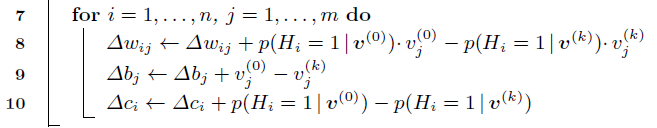


### Step - 10
**Creating 1st RBM object:**
* The weights and biases a and b will be initialized as only the init function will take action
* init function will take action because it is the default function and as soon as you create an object of a class, the init fucntion is called first and from this object we can call different functions defined in the class
* And the rest of the functions will be used while training


In [17]:
nv = len(train_set[0])      # no. of visible nodes
nh = 100                    # the features to be detected by RBM, hence can define any relevant number
batch_size = 100
rbm = RBM(nv, nh)

### Step - 11
* Training the RBM

In [18]:
nb_epoch = 10        # 10 because as we have a binary outcome and less data, the model will converge quickly

# creating a for loop to iterate through these epochs and in each epoch all observations go in the network 
# and then updating the weights after observations of each batch that passed through the network
# and then we get our final visible nodes with new ratings for the movies that were not orignally rated
for epoch in range(1, nb_epoch+1):
    train_loss = 0                      
    s = 0.                          
    
    for id_user in range(0, t_users - batch_size, batch_size):
        vk = train_set[id_user:id_user+batch_size]
        v0 = train_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0] 
    
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        
        train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[v0 >= 0]))
        s += 1.
        
    print('epoch: ' + str(epoch) + ' loss: ' + str(train_loss/s) )

epoch: 1 loss: tensor(0.3508)
epoch: 2 loss: tensor(0.2359)
epoch: 3 loss: tensor(0.2504)
epoch: 4 loss: tensor(0.2470)
epoch: 5 loss: tensor(0.2466)
epoch: 6 loss: tensor(0.2475)
epoch: 7 loss: tensor(0.2492)
epoch: 8 loss: tensor(0.2470)
epoch: 9 loss: tensor(0.2467)
epoch: 10 loss: tensor(0.2464)


**Understanding the for loop above:**
* `train_loss = 0` the loss variable as every NN has a parameter to minimize the loss function and this variable will increase every time we find errors between predictions and real ratings
* `s = 0.0` a float counter coz we want to normalize the train loss and to do se we divide this loss by counter, which will increase after every epoch
* Contrastive Divergence is to be done on all users in batch hence we need another for loop to get batches of users
* `range(0, t_users - batch_size, 100)` coz we want to go in batches from 0 to 943 in steps of 100. Batch is a hyper-parameter we can tune to get more/less better performance results on training set
* `vk` is the input of all observations/ratings in a batch
* `train_set[id_user:id_user+batch_size]` coz we want to get the range of every user from that `id_user` upto the `id_user + batch_size`
* `v0` are movies already rated by the 100 users in this batch
* `ph0` will be the probabilities that the hidden nodes will be one given the real ratings and we call the `sample_h` function we created above as it returns `p_h_given_v`. `ph0,_` will get us only the first argument in the return statement of that function
* Another for loop to implement k-step contrastive divergence
* `_,hk` are the hidden nodes obtained at k'th step of contrastive divergence and we want the 2nd element returned by the `sample_h` function
* `_,vk` will be sampled visible node after the 1st step of Gibbs samplings and we do that by calling the `sample_v` function on 1st sample of hidden node that is `hk` which was the result of 1st sampling based on 1st visible node
* Now, when `k` will be equal to 1, we enter into the 2nd step of Gibbs Sampling. Hence `hk` gets updated and since `vk` is the 1st sample of the visible node, the `sample_h(vk)` will return the 2nd sample of hidden node. Then this 2nd sample of hidden node will be the input of `sample_v` function and that will return the new sample of the visible nodes, i.e the 2nd sample of visible node. And again the ratings will be updated. This goes on and on as we get the 3rd sample of hidden node then the 3rd sample of visible node, etc until the end of the loop till we have 10th sample of hidden and visible node each
* We did this to approximate the Gradient to update the weights and bias. Coz to do that we need the last samples of hidden and visible nodes
* Now we don't want our model to train on the movies not rated(-1), hence we freeze the visible nodes which have a `-1` rating before training the RBM. In short, it won't be possible to update them using Gibbs sampling
* `vk[v0 < 0]` to get orignal(v0) ratings `-1` and we tell them to keep the `-1` ratings by `v0[v0<0]`
* The last essential element before applying the train function is `phk`. Hence we get it first by getting out of the for loop and applying `sample_h` function to last sample of the visible node after the 10 steps i.e. `vk`
* `train` doesn't return anything, it just updates the weight, hence we don't create a new variable
* Now training will take place, weights and biases will be updated towards the direction of maximum likelihood. The P(v|h) will be more relevant, and will get the largest weights for probabilities that are more significant. Eventually this will lead to predicted ratings being close to real ratings
* As we have our predictions now, we need to calculate `train_loss`
* `[v0 >= 0]` coz we need to consider the ratings that exist
* Update the counter `s` which normalizes the `train_loss` -> `(train_loss/s)`
* `print` function to check how we perform after every epoch and the loss associated with that respective epoch

**Conclusions from training loss obtained - 24.64%**
* This loss means we will be right 3 out of 4 times while predicting
* In simple words we got a **76%** accuracy in predicting the ratings of movies by all our users


### Step - 12
* Testing the RBM
* We will be testing the same on new samples/observations
* Let's make predictions on test set without doing any training of course and we will be calcuating `test_loss`
* This loss would be again nothing but the mean of the absolute distances between the predictions and the actual ratings
* So our goal is to hope that we get a `test_loss` around `0.2464`

In [19]:
test_loss = 0                      
s = 0.                          

for id_user in range(t_users):           
    v = train_set[id_user:id_user+1]      
    vt = test_set[id_user:id_user+1]      
    
    if len(vt[vt>=0]) > 0:           
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        
        test_loss += torch.mean(torch.abs(vt[vt >= 0] - v[vt >= 0]))
        s += 1.

print('test_loss: ' + str(test_loss/s) )

test_loss: tensor(0.2569)


**Conclusions from test loss of 25%**
* Here we also predict ratings correctly 3 times out of 4 or in short we get a **75%** accuracy

**Understanding the for loop above:**
* We don't need a batch size here as its only specific to training 
* `v` is input on which we will make predictions and we use `train_set` coz the input will be used to activate the hidden neurons to get the output `v`
* `vt` is the target and `test_set` coz we are comparing actual `test_set` results to predicted ones
* The `if loop` is for getting existing ratings from the target which contains orignal ratings of the test set
* Updating the `test_loss` and with `vt>0` we are only getting those cells which have an existing rating